# 10 - Cálculo del polinomio con la aproximación Cauer

El siguiente script busca a través de valores de una plantilla (por ahora normalizada), obtener el polinomio de la aproximación Cauer que la cumpla.

## Dependencias

In [2]:
#!pip install scipy scipyx numpy sympy matplotlib

In [3]:
import numpy as np
import sympy as sp
from scipy import signal
import scipy as sc
import scipyx as scx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display, Math


## Cálculo de F(w)

### Definimos los límites de la plantilla 

- $w_{an}$ 
- $G_p$
- $G_a$

In [4]:
# wan = 1.25
# Ga = 0.01
# Gp = 0.9

# Gp = 0.89125
# Ga = 0.003162277
# wan = 1.5



wan = 14.19
Ga = 10**(-40/20)# # -32db
Gp = 10**(-0.2/20)#  -3dB
plantilla_values ={'wp': 1, 'wa': wan, 'Ga': Ga, 'Gp': Gp}


### Función seno elíptico y cálculo de pseudoperíodo

In [5]:
def SenoEliptico(z, k) -> np.ndarray:
    """
    Función de seno elíptico

    :param complex z: Argumento del seno elíptico
    :param float k: Parámetro k del seno elíptico

    :return sn:  Valor del seno elíptico
    """
    sn, cn, dn, ph = scx.ellipj(u=z, m=k**2)

    #Usamos esta  porque recibe argumentos complejos y no sc.special.ellipk
    return sn

def L_SN(k) -> float:
    """
    Función que cálcula el pseudoperíodo real de un seno elíptico de parámetro k

    :param float k: Constante k del seno elíptico

    :returns L: Valor de L
    """
    return float(np.real(sc.special.ellipk(k**2))) if not isinstance(k, np.ndarray) else np.real(sc.special.ellipk(k**2)).astype(float)


def Li_SN(k) -> float:
    """
    Función que cálcula el pseudoperíodo imaginario  de un seno elíptico de parámetro k

    :param float k: Constante k del seno elíptico

    :return Li: Valor de Li
    """
    return float(sc.special.ellipk(1-k**2)) if not isinstance(k, np.ndarray) else sc.special.ellipk(1-k**2).astype(float)

A partir de los datos de la plantilla obtenemos $k_1$ y $k_2$

$k_1 = \frac{\sqrt{\frac{1}{G_p^2} -1 }}{\sqrt{\frac{1}{G_a^2} -1 }}$

$k_2 =  \frac{1}{w_{an}}$

In [6]:
k1 =  np.sqrt(1/(Gp**2)-1)/ np.sqrt(1/(Ga**2)-1)
print('El valor de k1 es: ', k1)
print('El valor de 1/k1 es: ', 1/k1)
k2 = 1/wan
print('El valor de k2 es: ', k2)


El valor de k1 es:  0.00217101960785796
El valor de 1/k1 es:  460.61306695735084
El valor de k2 es:  0.07047216349541931


A partir de  $k_1$ y $k_2$ podemos obtener los pseudoperíodos 

In [7]:
L1 = L_SN(k1)
Li1 = Li_SN(k1)

print('El valor de L1 es: ', L1)
print('El valor de Li1 es: ', Li1)


L2 = L_SN(k2)
Li2 = Li_SN(k2)

print('El valor de L2 es: ', L2)
print('El valor de Li2 es: ', Li2)

El valor de L1 es:  1.5707981777186497
El valor de Li1 es:  7.518860398917608
El valor de L2 es:  1.5727520654458922
El valor de Li2 es:  4.042614805160723


In [8]:
display(SenoEliptico(z=(5*L1+1j*Li1),k=k1))

np.complex128(460.61306695667963+1.5515377325814326e-26j)

### Cálculo del orden

Sacamos el orden 

$ N \geq \frac{L_{2} \cdot L_{i1}}{L_{i2} \cdot L_{1}}$

In [9]:
N  = (L2 * Li1)/(Li2 * L1)
print(N)
N = int(np.ceil(N)) #Tomamos el entero más cercano

print('El valor del orden es', int(N))


1.8622137743937517
El valor del orden es 2


### Construimos F(w)

Ya tenemos todos los datos para sacar los polos y ceros de  $F(\omega)$ a través la función $S_{n_{k2}}$

Para N par:

- $wz = S_{n_{k2}}( (2*n -1) * \frac{L_2}{N} )$

-  $wp = S_{n_{k2}}( (2*n -1) * \frac{L_2}{N}  + jL_{2_i} )$


Para N impar:
 
- $wz = S_{n_{k2}}( (2*n) * \frac{L_2}{N} )$

- $wp = S_{n_{k2}}( (2*n) * \frac{L_2}{N}  + jL_{2_i}  )$


In [10]:

def get_zeros(N, k2) -> list:
    """
    Función que obtiene los ceros de F(w)  que cumple plantilla
    
    :param int N: orden del filtro
    :param float k2: parámetro del seno elíptico

    :return zeros: lista de ceros 
    """
    L2 = L_SN(k2)
    zeros= []


    #Par
    if N%2 == 0:
        for n in range(-int(N/2), int(N/2)):
            lugar_del_cero =  (2*n + 1)*L2/N
            zn =  SenoEliptico(z = lugar_del_cero, k= k2)
            zeros.append(zn)

    #Impar
    elif N%2 != 0:
        for n in range(-int(np.floor(N/2)), int(np.floor(N/2)) + 1):   #+1 porque range no toma el último 
            lugar_del_cero =  (2*n)*L2/N
            zn =  SenoEliptico(z = lugar_del_cero, k= k2)
            zeros.append(zn)

    return zeros


def get_poles (N, k2) -> list:
    """
    Función que obtiene los polos de  F(w)  que cumple plantilla
    
    :param int N: orden del filtro
    :param float k2: parámetro del seno elíptico

    :return polser: lista de polos 
    """
        
    L2 = L_SN(k2)
    Li2 = Li_SN(k2)

    poles = []

    #Par
    if N%2 == 0:
        for n in range(-int(N/2), int(N/2)):
            lugar_del_polo =  (2*n + 1)*L2/N + 1j*Li2
            pn =  SenoEliptico(z = lugar_del_polo, k= k2)
            poles.append(np.real(pn))   #Eliminamos el error  (parte imaginaria)

    #Impar
    elif N%2 != 0:
        for n in range(-int(np.floor(N/2)), int(np.floor(N/2)) + 1):   #+1 porque range no toma el último 
            if n != 0:                                                  #Si n es cero, entonces el argumetno es j*Li2 y en ese punto el seno eliptico da infinito w = infinito
                lugar_del_polo =  (2*n)*L2/N + 1j*Li2
                pn =  SenoEliptico(z = lugar_del_polo, k= k2)
                poles.append(np.real(pn))  #Eliminamos el error (parte imaginaria)

    poles2 = []
    for zi in zeros:
        if(zi!=0):
            poles2.append(1/(zi*k2))

    print('Polos calculados a carbón  ', poles2)
    return poles


zeros = get_zeros(N, k2)
poles = get_poles(N, k2)

print('Polos con cálculo anterior ', poles)
print('Los ceros son ', zeros)

Polos calculados a carbón   [np.float64(-20.05521322905707), np.float64(20.05521322905707)]
Polos con cálculo anterior  [np.float64(-20.055213229056616), np.float64(20.055213229056616)]
Los ceros son  [np.float64(-0.707546703090684), np.float64(0.707546703090684)]


Obtenemos el polinomio $F(\omega)$

In [11]:
num = np.poly(zeros)
den = np.poly(poles)
#Par
if N%2 == 0:
    Gain = np.cumprod(poles)[-1]/np.cumprod(zeros)[-1]
    F_in_0 = Gain * np.polyval(num, 0)/np.polyval(den, 0)  #Función elíptica
    print(F_in_0)

#Impar  
else: 
    zeros_without_zero = [(1-zero) for zero in zeros]    
    poles_correct =  [(1-pole) for pole in poles ]
    Gain = np.cumprod(poles_correct)[-1]/np.cumprod(zeros_without_zero)[-1]
    F_in_1 = Gain * np.polyval(num, 1)/np.polyval(den, 1)  #Función elíptica
    print("Se calcula la ganancia en 1, para verificar que está bien normalizado en amplitud: ",F_in_1)


w_points = np.linspace(4*np.min(poles), 4*np.max(poles), 10000 )

F_values = []
F_values_log = []
prev_value=0
for point in w_points : 
    F_value = Gain * np.polyval(num, point)/np.polyval(den, point)  #Función elíptica
    
    if (prev_value*F_value < 0) and (abs(prev_value-F_value)>1): #Tienen distinto signo y es un salto grande. Esto elimina las discontinuidades
        F_values.append(np.nan)
    else:
        F_values.append(F_value)

    prev_value=F_value

    #F_values_log.append( np.sign(F_value) * np.log2(np.abs(F_value) + 1))


1.0


1/k1 de la plantilla: 460.61306695735084


Evaluando esta función en 1/k2 se obtiene el verdadero 1/k1 para el orden entero:
-803.4231553259276


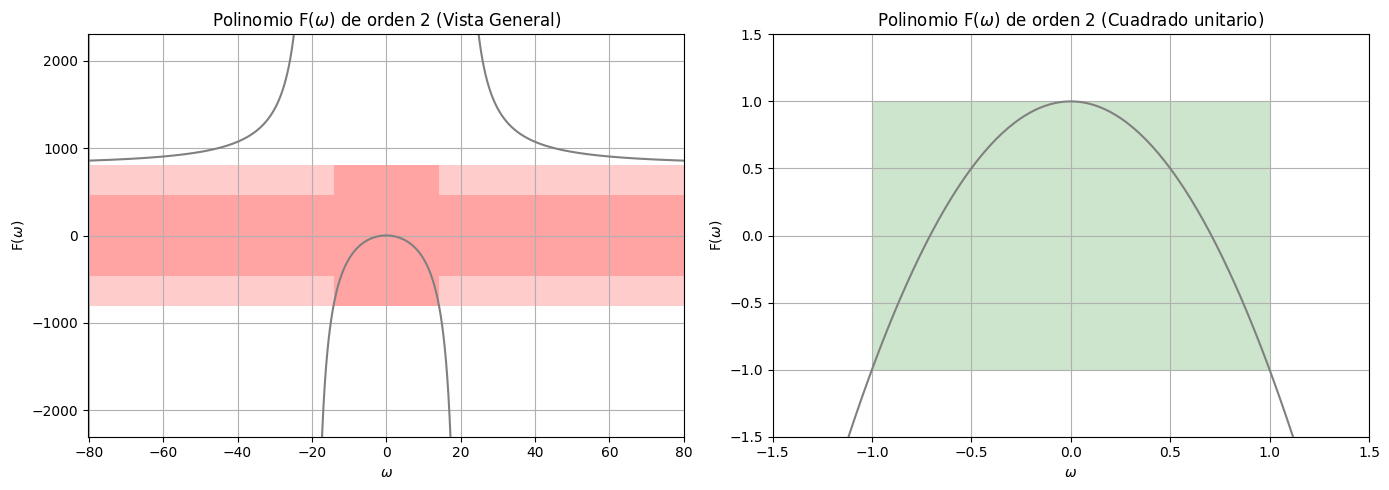

In [12]:
#Comprobación del márgen

print('1/k1 de la plantilla:', 1/k1)
print('\n')

print('Evaluando esta función en 1/k2 se obtiene el verdadero 1/k1 para el orden entero:') #Función elíptica
k1real=1/( Gain * np.polyval(num, 1/k2)/np.polyval(den,1/k2))
print(1/k1real)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Wider figure to accommodate both plots

# First subplot - original scale
ax1.plot(w_points, F_values, color="gray")
ax1.add_patch(Rectangle((1/k2, -1/k1), 2*1/k1, 2*1/k1, facecolor='red', alpha=0.2))
ax1.add_patch(Rectangle((-1/k2, -1/k1), -2*1/k1, 2*1/k1, facecolor='red', alpha=0.2))

ax1.add_patch(Rectangle((1/k2, -1/k1real), 2*1/k1real, 2*1/k1real, facecolor='red', alpha=0.2))
ax1.add_patch(Rectangle((-1/k2, -1/k1real), -2*1/k1real, 2*1/k1real, facecolor='red', alpha=0.2))

ax1.set_ylim([5*(-1/k1), 5*(1/k1)])
ax1.set_xlim([np.min(w_points), np.max(w_points)])
ax1.grid()
ax1.set_title('Polinomio F($\\omega$) de orden '+ str(int(N)) + ' (Vista General)')
ax1.set_xlabel('$\\omega$')
ax1.set_ylabel('F($\\omega$)')

# Second subplot - zoomed in scale
ax2.plot(w_points, F_values, color="gray")
ax2.add_patch(Rectangle((-1, -1), 2, 2, facecolor='green', alpha=0.2))
ax2.set_ylim([-1.5, 1.5])
ax2.set_xlim([-1.5, 1.5])
ax2.grid()
ax2.set_title('Polinomio F($\\omega$) de orden '+ str(int(N)) + ' (Cuadrado unitario)')
ax2.set_xlabel('$\\omega$')
ax2.set_ylabel('F($\\omega$)')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


## Conseguimos  G(w) y |H(s)|

In [13]:
from sympy.abc import s,w,xi,p 


In [14]:
def get_poly_Cauer(zeros,poles):

    x = sp.symbols('x')
    #Par
    if N%2 == 0:
        Gain = np.cumprod(poles)[-1]/np.cumprod(zeros)[-1]
       

    #Impar  
    else: 
        zeros_for_gain = [(1-zero) for zero in zeros]     # En w = 1 tiene que dar 1, normalizo la ganancia en ese valor
        poles_for_gain =  [(1-pole) for pole in poles ]
        Gain = np.cumprod(poles_for_gain)[-1]/np.cumprod(zeros_for_gain)[-1]

    num =  sp.expand(sp.prod([(x - zero) for zero in zeros]))
    den = sp.expand(sp.prod([(x - pole) for pole in poles]))
    F_poly =  Gain * num/den
    return F_poly, x

In [15]:

F = np.array(F_values)  
F2 = F*xi  
F3 = (F2)**2
F4 = (F3)+1
F5 = 1/F4

F_poly, x = get_poly_Cauer(zeros, poles)

G= 1/(1+(xi*p)**2) # Acá p es un polinomio


display('Transformación del polinomio (nótese que p es un polinomio): ', G)

cauer_p = F_poly.subs(x, w)
#Reemplazo cheby en la transformación 
G = G.subs(p, cauer_p)

display('Reemplazamos p por el polinomio de Cauer orden ' + str(N),  G)
display('Reemplazamos p por el polinomio de Cauer orden ' + str(N),  sp.simplify(G))

# Fsw

C:\Users\samma\AppData\Local\Temp\ipykernel_19188\3888375821.py:2: RuntimeWarning: invalid value encountered in multiply
  F2 = F*xi


'Transformación del polinomio (nótese que p es un polinomio): '

1/(p**2*xi**2 + 1)

'Reemplazamos p por el polinomio de Cauer orden 2'

1/(xi**2*(803.423155325855*w**2 - 402.211577662927)**2/(w**2 - 402.211577662927)**2 + 1)

'Reemplazamos p por el polinomio de Cauer orden 2'

(w**2 - 402.211577662927)**2/(xi**2*(803.423155325855*w**2 - 402.211577662927)**2 + (w**2 - 402.211577662927)**2)

In [24]:
#Evaluamos en w = 1
G_xi = G.subs(w, 1)
eq_xi = sp.Eq(G_xi,Gp**2)


#Obtenemos el valor de xi 
sol_xi = sp.solve(eq_xi)            
sol_xi = sol_xi[1]    #Consigo el valor positivo 



display('El resultado positivo fue: ')
display(Math(f'\\xi = {sol_xi:.2f}'))


#Se reemplaza xi en la expresión del polinomio transformado
G_xi = G.subs(xi, 217e-3)

display('Sustituyendo xi, la tranformación resulta:  ')
display(G_xi.simplify())

'El resultado positivo fue: '

<IPython.core.display.Math object>

'Sustituyendo xi, la tranformación resulta:  '

(w**2 - 402.211577662927)**2/((w**2 - 402.211577662927)**2 + 0.047089*(803.423155325855*w**2 - 402.211577662927)**2)

In [56]:
def get_zeros_and_poles(F):
    """
    Función que calcula los ceros y los polos de una función transferencia
    
    :param F: función transferencia como expresión de sympy

    :returns: ceros y polos de la función transferencias
    """

    #Obtenemos  el numerador y denominador de la expresión
    num = sp.fraction(F)[0]
    den = sp.fraction(F)[1]
    

    #Obtenemos los coeficientes del numerador y denominador. Los ifs son para los casos donde el numerador o denominador son de orden 1. 

    #si es de orden 1

    print(type(num))
    print(type(den))

    #Si no tiene ceros
    if num.is_number:
        num_coeffs = num
    #Si tiene ceros
    else:
        num_coeffs = sp.Poly(num).all_coeffs()

    #Si no tiene polos

    if den.is_number:
    
        den_coeffs = den
    #Si tiene polos
    else:
        den_coeffs = sp.Poly(den).all_coeffs()

    #Para mejor manejo vamos a pasar estos coeficientes a un tipo de arreglo de numpy (confíen)
    num_coeffs = np.array(num_coeffs, dtype = float)
    den_coeffs = np.array(den_coeffs, dtype = float)

    

    #Obtenemos las raíces de esos polinomios. 
    #Esto lo vamos a hacer a través de scipy, que tiene una función que a partir de los coeficientes del numerador y denominador, te da los polos y ceros
    
    pz = signal.tf2zpk(num_coeffs,den_coeffs)

    #pz es una arreglo [ceros, polos, ganancia]

    zeros = pz[0]
    poles = pz[1]

    return zeros, poles

def plot_pz_map(zeros, poles):
    """
    Función que grafica el PZ map diagrama de polos y ceros. 
        
    :param zeros: lista de ceros
    :param poles: lista de polos

    """
    plt.figure(figsize=(8, 6))
    zeros_parte_real = np.real(zeros)
    zeros_parte_imaginaria =  np.imag(zeros)
    plt.scatter(zeros_parte_real,zeros_parte_imaginaria, marker='o', color='b')

    poles_parte_real = np.real(poles)
    poles_parte_imaginaria =  np.imag(poles)
    plt.scatter(poles_parte_real,poles_parte_imaginaria, marker='x', color='b')

    #Pueden cambiar este límite como quieram
    # plt.ylim([-5, 5])
    # plt.xlim([-5, 5])

    plt.xlabel('$\\sigma$')
    plt.ylabel('$j\\omega$')

    plt.grid()
    plt.show()
    
def plot_transfer_heatmap(H, poles, zeros, padding=1000, resolution=800):
    """
    Grafica el módulo logarítmico de H(s) como imagen en el plano complejo,
    ajustando automáticamente los rangos según polos y ceros.

    :param H: función de transferencia H(s), donde s es complejo
    :param poles: lista de polos
    :param zeros: lista de ceros
    :param padding: margen adicional en cada eje
    :param resolution: cantidad de puntos en cada eje
    """
    all_points = np.array(poles + zeros)
    real_min, real_max = np.real(all_points).min(), np.real(all_points).max()
    imag_min, imag_max = np.imag(all_points).min(), np.imag(all_points).max()

    real_range = (real_min - padding, real_max + padding)
    imag_range = (imag_min - padding, imag_max + padding)

    sigma = np.linspace(real_range[0], real_range[1], resolution)
    omega = np.linspace(imag_range[0], imag_range[1], resolution)
    S = sigma[np.newaxis, :] + 1j * omega[:, np.newaxis]

    H_vals = H(S)
    log_mag = 20*np.log10(np.abs(H_vals) + 1e-10)

    plt.scatter(np.real(zeros), np.imag(zeros), marker='o', color='blue', label='Ceros')
    plt.scatter(np.real(poles), np.imag(poles), marker='x', color='red', label='Polos')
    plt.legend()

    plt.figure(figsize=(8, 6))
    plt.imshow(log_mag, extent=(real_range[0], real_range[1], imag_range[0], imag_range[1]),
               origin='lower', cmap='viridis' , aspect='auto')
    plt.colorbar(label=r'$|H(s)|(dB)$')
    plt.xlabel(r'$\sigma$')
    plt.ylabel(r'$\omega$')
    plt.title("Magnitud $|H(s)|(dB)$ en el plano s")
    plt.axhline(0, color='black', lw=1)
    plt.axvline(0, color='black', lw=1)
    plt.grid(False)
    plt.show()


def plot_bode(mag, w, plantilla_values, xlim1=None, ylim1=None, xlim2=None, ylim2=None):
    """
    Función que plotea el módulo de la respuesta en frecuencia de un sistema en dos escalas diferentes.

    :param mag: valores de magnitud
    :param w: valores de frecuencia
    :param plantilla_values: diccionario con valores de la plantilla (wa, Ga, Gp)
    :param xlim1: límites del eje x para el primer gráfico (tuple). Default: [0, 6]
    :param ylim1: límites del eje y para el primer gráfico (tuple). Default: [0, 0.012]
    :param xlim2: límites del eje x para el segundo gráfico (tuple). Default: [0, 1.5]
    :param ylim2: límites del eje y para el segundo gráfico (tuple). Default: [0.8, 1.2]
    """
    # Set default limits if not provided
    if xlim1 is None:
        xlim1 = [0, 6]
    if ylim1 is None:
        ylim1 = [0, 0.012]
    if xlim2 is None:
        xlim2 = [0, 1.5]
    if ylim2 is None:
        ylim2 = [0.8, 1.2]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Extract template values
    wa = plantilla_values['wa']
    wp = 1
    Ga = plantilla_values['Ga']  # -32db
    Gp = plantilla_values['Gp']  # -2.5dB

    # First plot (wide scale)
    ax1.plot(w, mag)
    ax1.add_patch(Rectangle((0, 1), wp, -(1 - Gp), facecolor='green', alpha=0.2))
    ax1.add_patch(Rectangle((wa, 0), 10, Ga, facecolor='red', alpha=0.2))
    #ax1.set_xlim(xlim1)
    #ax1.set_ylim(ylim1)
    ax1.set_ylabel('Módulo [v/v]')
    ax1.set_xlabel('$\\omega$ [rad/s]')
    ax1.grid()
    ax1.set_title('Escala completa')

    # Second plot (zoomed scale)
    ax2.plot(w, mag)
    ax2.add_patch(Rectangle((0, 1), wp, -(1 - Gp), facecolor='green', alpha=0.2))
    ax2.add_patch(Rectangle((wa, 0), 10, Ga, facecolor='red', alpha=0.2))
    #ax2.set_xlim(xlim2)
    #ax2.set_ylim(ylim2)
    ax2.set_xlabel('$\\omega$ [rad/s]')
    ax2.grid()
    ax2.set_title('Escala ampliada')

    plt.suptitle('Módulo de la respuesta en frecuencia')
    plt.tight_layout()
    plt.show()



In [18]:
G_n = G_xi.subs(w, wan)
print('Ga**2 = ', Ga**2)

print('La transformación evaluada en w = wa da', G_n)

if G_n < Ga**2:
    print('La transformación con Chebyshev de orden 8 cumple con la plantilla')

Ga**2 =  0.0001
La transformación evaluada en w = wa da 3.28986105167354e-5
La transformación con Chebyshev de orden 8 cumple con la plantilla


In [19]:
B = (2.667e3 - 2.16e3)*2*np.pi
wo =np.sqrt(2.667e3 * 2.16e3) *2*np.pi


Gs_aux = G_xi.subs(w, s/sp.I) #sp.I es el número imaginario
Gs = Gs_aux.subs(s, (s**2 + wo**2) / (B * s))

display(f'Realizando el cambio de variable de w = s/j: ')
display(sp.factor(sp.simplify(Gs)))

'Realizando el cambio de variable de w = s/j: '

3.28986105167413e-5*(3.7381264289554e-34*s**8 + 3.39156186308661e-24*s**6 + 7.73148737924906e-15*s**4 + 1.75417432534583e-7*s**2 + 1.0)/(3.7381264289554e-34*s**8 + 3.43954425914614e-25*s**6 + 1.17993112151619e-16*s**4 + 1.77899164864231e-8*s**2 + 1.0)

In [ ]:
#Obtenemos todos los polos y ceros de Fs

zeros_f, poles_f = get_zeros_and_poles(sp.simplify(Gs)) #sin el simplify se rompe



print('ceros: ', list(zeros_f))
print('polos: ', list(poles_f))

#Hacemos el diagrama de polos y ceros
plot_pz_map(zeros_f,poles_f)




<class 'sympy.core.add.Add'>
<class 'sympy.core.add.Add'>
ceros:  [np.complex128(-0.000891858663635503+67268.23912963682j), np.complex128(-0.000891858663635503-67268.23912963682j), np.complex128(0.0008918586772779236+67268.23909261452j), np.complex128(0.0008918586772779236-67268.23909261452j), np.complex128(-1.8583250493975356e-08+3380.854291176334j), np.complex128(-1.8583250493975356e-08-3380.854291176334j), np.complex128(1.8583023120299913e-08+3380.8541426084253j), np.complex128(1.8583023120299913e-08-3380.8541426084253j)]
polos:  [np.complex128(-1723.8165680266711+17034.50220466787j), np.complex128(-1723.8165680266711-17034.50220466787j), np.complex128(1723.8165680266643+17034.502204667893j), np.complex128(1723.8165680266643-17034.502204667893j), np.complex128(-1337.346250971068+13215.459279782981j), np.complex128(-1337.346250971068-13215.459279782981j), np.complex128(1337.3462509710687+13215.459279782977j), np.complex128(1337.3462509710687-13215.459279782977j)]


In [57]:
#Obtenemos solamente los polos que tienen parte real negativa (los del lado izquierdo del diagrama de polos)
useful_poles_f = [p for p in poles_f if np.real(p) < 0]

#Obtenemos los ceros  que tienen parte real negativa
useful_zeros_f = [z for z in zeros_f if np.real(z) < 0]


display('ceros: ', [zero/(2*np.pi) for zero  in list(useful_zeros_f)] )
display('polos del lado izquierdo: ',  [pole/(2*np.pi) for pole  in list(useful_poles_f)])


#Hacemos el diagrama de polos y ceros
plot_pz_map(useful_zeros_f,useful_poles_f)

def H(s):
    num = np.ones_like(s)
    den = np.ones_like(s)
    for z in useful_zeros_f:
        num *= (s - z)
    for p in useful_poles_f:
        den *= (s - p)
    return num / den


plot_transfer_heatmap(H,useful_poles_f,useful_zeros_f)

'ceros: '

[np.complex128(-0.0001419437148569223+10706.072770569355j),
 np.complex128(-0.0001419437148569223-10706.072770569355j),
 np.complex128(-2.957616174831084e-09+538.0796723141596j),
 np.complex128(-2.957616174831084e-09-538.0796723141596j)]

'polos del lado izquierdo: '

[np.complex128(-274.3539277851512+2711.1252289826807j),
 np.complex128(-274.3539277851512-2711.1252289826807j),
 np.complex128(-212.8452664674599+2103.3056696071208j),
 np.complex128(-212.8452664674599-2103.3056696071208j)]

La ganancia es:  (0.9772371774743589+1.0997832517497724e-27j)


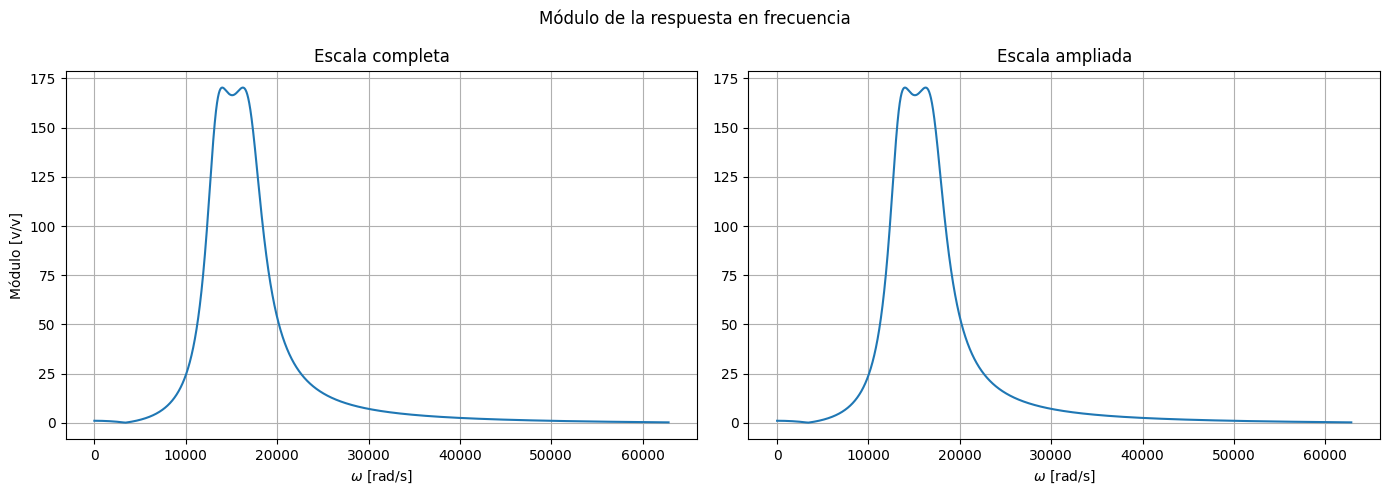

In [22]:
#Obtenemos la respuesta en frecuencia 

#Par
if N%2 == 0:
    gain = np.cumprod(useful_poles_f)[-1]*(Gp)/np.cumprod(useful_zeros_f)[-1] #Magic number?? Cómo es que a veces va Gp y otras no...
#Impar
else:
    gain = np.cumprod(useful_poles_f)[-1]*(1)/np.cumprod(useful_zeros_f)[-1] #Magic number?? Cómo es que a veces va Gp y otras no...

print('La ganancia es: ', gain)

#Define un sistema de scipy a través de los ceros, polos y ganancia 
tf = signal.ZerosPolesGain(useful_zeros_f, useful_poles_f, gain )


w_axis = np.linspace(0,10e3*2*np.pi,150000)

w_axis, mag, phase = signal.bode(tf, w = w_axis)
mag_en_veces = 10**(mag/20)
plot_bode(mag_en_veces, w_axis,  plantilla_values = plantilla_values, 
          xlim1=[0, 10e3*2*np.pi], ylim1=[0, Gp],
          xlim2=[1, 10e3*2*np.pi], ylim2=[0, 1.5*Ga])

In [23]:
#Transforma a pasa banda


